In [1]:
import os
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import gymnasium as gym
import matplotlib.pyplot as plt
import imageio

In [2]:
# Replay Buffer
class ReplayBuffer:
    def __init__(self, max_size, input_shape, n_actions):
        self.mem_size = max_size
        self.mem_cntr = 0

        self.state_memory = np.zeros((max_size, *input_shape), dtype=np.float32)
        self.new_state_memory = np.zeros((max_size, *input_shape), dtype=np.float32)
        self.action_memory = np.zeros((max_size, n_actions), dtype=np.float32)
        self.reward_memory = np.zeros(max_size, dtype=np.float32)
        self.terminal_memory = np.zeros(max_size, dtype=np.bool_)

    def store_transition(self, state, action, reward, new_state, done):
        index = self.mem_cntr % self.mem_size

        self.state_memory[index] = state
        self.new_state_memory[index] = new_state
        self.action_memory[index] = action
        self.reward_memory[index] = reward
        self.terminal_memory[index] = done

        self.mem_cntr += 1

    def sample_buffer(self, batch_size):
        max_mem = min(self.mem_cntr, self.mem_size)
        batch = np.random.choice(max_mem, batch_size)

        states = self.state_memory[batch]
        actions = self.action_memory[batch]
        rewards = self.reward_memory[batch]
        new_states = self.new_state_memory[batch]
        terminals = self.terminal_memory[batch]

        return states, actions, rewards, new_states, terminals

In [3]:
# Critic Network
class CriticNetwork(keras.Model):
    def __init__(self, fc1_dims, fc2_dims, name, chkpt_dir='tmp/td3'):
        super().__init__()

        self.model_name = name
        self.checkpoint_file = os.path.join(chkpt_dir, name + "_td3.weights.h5")

        self.fc1 = Dense(fc1_dims, activation='relu')
        self.fc2 = Dense(fc2_dims, activation='relu')
        self.q = Dense(1, activation=None)

    def call(self, state, action):
        x = tf.concat([state, action], axis=1)
        x = self.fc1(x)
        x = self.fc2(x)
        q = self.q(x)
        return q


In [4]:
# Actor Network
class ActorNetwork(keras.Model):
    def __init__(self, fc1_dims, fc2_dims, n_actions, name, chkpt_dir='tmp/td3'):
        super().__init__()

        self.model_name = name
        self.checkpoint_file = os.path.join(chkpt_dir, name + "_td3.weights.h5")

        self.fc1 = Dense(fc1_dims, activation='relu')
        self.fc2 = Dense(fc2_dims, activation='relu')
        self.mu = Dense(n_actions, activation='tanh')

    def call(self, state):
        x = self.fc1(state)
        x = self.fc2(x)
        mu = self.mu(x)
        return mu

In [5]:
# Agent
class Agent:
    def __init__(self, alpha, beta, input_dims, tau, env,
                 gamma=0.99, update_actor_interval=2, warmup=1000,
                 n_actions=1, max_size=1000000, layer1_size=256, layer2_size=256,
                 batch_size=256, noise=0.1):
        
        self.gamma = gamma
        self.tau = tau
        self.max_action = env.action_space.high[0]
        self.min_action = env.action_space.low[0]
        self.n_actions = n_actions

        self.memory = ReplayBuffer(max_size, input_dims, n_actions)
        self.batch_size = batch_size
        self.learn_step_cntr = 0
        self.time_step = 0
        self.warmup = warmup
        self.update_actor_iter = update_actor_interval

        # Networks
        self.actor = ActorNetwork(layer1_size, layer2_size, n_actions, name='actor')
        self.critic_1 = CriticNetwork(layer1_size, layer2_size, name='critic_1')
        self.critic_2 = CriticNetwork(layer1_size, layer2_size, name='critic_2')

        self.target_actor = ActorNetwork(layer1_size, layer2_size, n_actions, name='target_actor')
        self.target_critic_1 = CriticNetwork(layer1_size, layer2_size, name='target_critic_1')
        self.target_critic_2 = CriticNetwork(layer1_size, layer2_size, name='target_critic_2')

        # Optimizers
        self.actor.compile(optimizer=Adam(learning_rate=alpha))
        self.critic_1.compile(optimizer=Adam(learning_rate=beta), loss='mean_squared_error')
        self.critic_2.compile(optimizer=Adam(learning_rate=beta), loss='mean_squared_error')

        self.noise = noise
        self.update_network_parameters(tau=1)

    # Choose action
    def choose_action(self, observation):
        if self.time_step < self.warmup:
            mu = np.random.normal(scale=self.noise, size=(self.n_actions,))
        else:
            state = tf.convert_to_tensor([observation], dtype=tf.float32)
            mu = self.actor(state)[0].numpy()

        mu_prime = mu + np.random.normal(scale=self.noise, size=mu.shape)
        mu_prime = np.clip(mu_prime, self.min_action, self.max_action)

        self.time_step += 1
        return mu_prime
    
    # Store transition
    def remember(self, state, action, reward, new_state, done):
        self.memory.store_transition(state, action, reward, new_state, done)

    # Soft udpate
    def update_network_parameters(self, tau=None):
        if tau is None:
            tau = self.tau
        
        def soft_update(net, target_net):
            weights = []
            target_weights = target_net.weights
            for i, w in enumerate(net.weights):
                weights.append(w * tau + target_weights[i] * (1 - tau))
            target_net.set_weights(weights)

        soft_update(self.actor, self.target_actor)
        soft_update(self.critic_1, self.target_critic_1)
        soft_update(self.critic_2, self.target_critic_2)

    # Learning
    def learn(self):
        if self.memory.mem_cntr < self.batch_size:
            return None, None, None
        
        states, actions, rewards, new_states, dones = self.memory.sample_buffer(self.batch_size)

        states = tf.convert_to_tensor(states, dtype=tf.float32)
        actions = tf.convert_to_tensor(actions, dtype=tf.float32)
        rewards = tf.convert_to_tensor(rewards, dtype=tf.float32)
        new_states = tf.convert_to_tensor(new_states, dtype=tf.float32)
        dones = tf.convert_to_tensor(dones, dtype=tf.float32)

        # Critic update
        with tf.GradientTape(persistent=True) as tape:
            noise = tf.clip_by_value(tf.random.normal(shape=(self.batch_size, self.n_actions), stddev=0.2),
                                        -0.5, 0.5)
            target_actions = self.target_actor(new_states) + noise
            target_actions = tf.clip_by_value(target_actions, self.min_action, self.max_action)

            q1_next = tf.squeeze(self.target_critic_1(new_states, target_actions), 1)
            q2_next = tf.squeeze(self.target_critic_2(new_states, target_actions), 1)
            q_min = tf.minimum(q1_next, q2_next)

            target_q = rewards + self.gamma * q_min * (1 - dones)

            q1 = tf.squeeze(self.critic_1(states, actions), 1)
            q2 = tf.squeeze(self.critic_2(states, actions), 1)

            critic_1_loss = keras.losses.MSE(target_q, q1)
            critic_2_loss = keras.losses.MSE(target_q, q2)

        critic_1_grad = tape.gradient(critic_1_loss, self.critic_1.trainable_variables)
        critic_2_grad = tape.gradient(critic_2_loss, self.critic_2.trainable_variables)

        self.critic_1.optimizer.apply_gradients(zip(critic_1_grad, self.critic_1.trainable_variables))
        self.critic_2.optimizer.apply_gradients(zip(critic_2_grad, self.critic_2.trainable_variables))

        self.learn_step_cntr += 1
        actor_loss_value = None

        # Delayed Actor update
        if self.learn_step_cntr % self.update_actor_iter == 0:
            with tf.GradientTape() as tape2:
                new_actions = self.actor(states)
                critic_value = self.critic_1(states, new_actions)
                actor_loss = -tf.reduce_mean(critic_value)
            
            actor_grad = tape2.gradient(actor_loss, self.actor.trainable_variables)
            self.actor.optimizer.apply_gradients(zip(actor_grad, self.actor.trainable_variables))
            actor_loss_value = actor_loss.numpy()

            self.update_network_parameters()
        
        return critic_1_loss.numpy(), critic_2_loss.numpy(), actor_loss_value
    

In [6]:
# Training
if __name__ == "__main__":
    os.makedirs("plots", exist_ok=True)
    os.makedirs("videos", exist_ok=True)
    os.makedirs("tmp/td3", exist_ok=True)

    env = gym.make("Pendulum-v1", render_mode="human")
    eval_env = gym.make("Pendulum-v1", render_mode="rgb_array")

    agent = Agent(
        alpha=3e-4, beta=3e-4,
        input_dims=env.observation_space.shape,
        tau=0.005, env=env,
        n_actions=env.action_space.shape[0],
        batch_size=256, warmup=1000
    )

    n_episodes = 200
    max_steps = 200

    episode_rewards = []
    eval_rewards = []
    critic1_losses = []
    critic2_losses = []
    actor_losses = []

    for ep in range(n_episodes):
        observation, _ = env.reset()
        done = False
        truncated = False
        score = 0

        for _ in range(max_steps):
            action = agent.choose_action(observation)
            observation_new, reward, done, truncated, _ = env.step(action)
            agent.remember(observation, action, reward, observation_new, done)

            c1, c2, a_loss = agent.learn()
            if c1 is not None:
                critic1_losses.append(c1)
                critic2_losses.append(c2)
            if a_loss is not None:
                actor_losses.append(a_loss)
                
            observation = observation_new
            score += reward

            if done or truncated:
                break

        episode_rewards.append(score)
        print(f"Episode {ep+1}/{n_episodes}, Reward: {score:.2f}")
    
    # # Save model
    # agent.save_models()

/Users/chetankumar/anaconda3/envs/env_rl_v1/lib/python3.10/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


Episode 1/200, Reward: -1308.95
Episode 2/200, Reward: -1065.71
Episode 3/200, Reward: -1770.25
Episode 4/200, Reward: -1052.72
Episode 5/200, Reward: -1104.66
Episode 6/200, Reward: -1737.23
Episode 7/200, Reward: -1744.64
Episode 8/200, Reward: -1617.14
Episode 9/200, Reward: -1309.59
Episode 10/200, Reward: -1544.10
Episode 11/200, Reward: -1425.56
Episode 12/200, Reward: -1521.00
Episode 13/200, Reward: -1211.95
Episode 14/200, Reward: -1343.82
Episode 15/200, Reward: -1288.11
Episode 16/200, Reward: -1515.64
Episode 17/200, Reward: -1179.37
Episode 18/200, Reward: -1729.62
Episode 19/200, Reward: -1014.07
Episode 20/200, Reward: -1290.82
Episode 21/200, Reward: -1159.33
Episode 22/200, Reward: -1103.47
Episode 23/200, Reward: -1231.21
Episode 24/200, Reward: -1096.21
Episode 25/200, Reward: -1196.40
Episode 26/200, Reward: -757.37
Episode 27/200, Reward: -1012.52
Episode 28/200, Reward: -989.48
Episode 29/200, Reward: -1045.12
Episode 30/200, Reward: -1213.40
Episode 31/200, Rewar

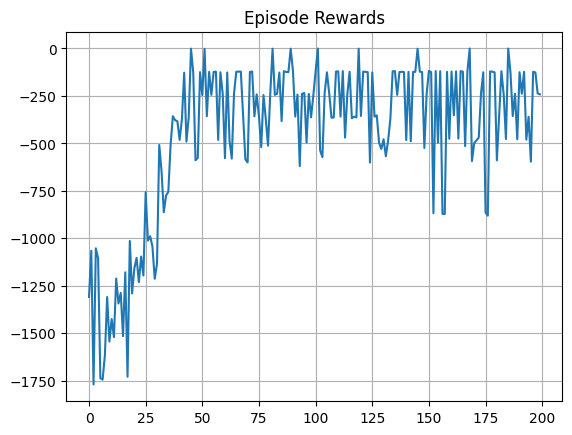

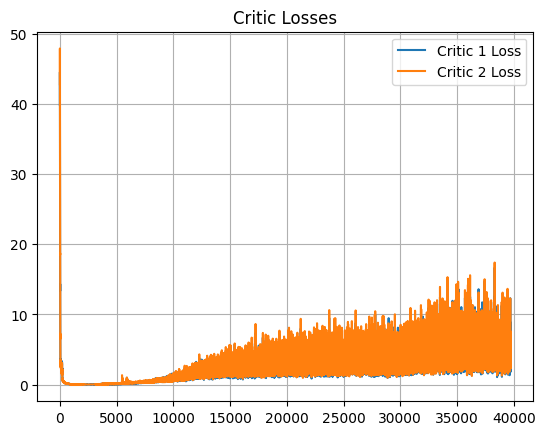

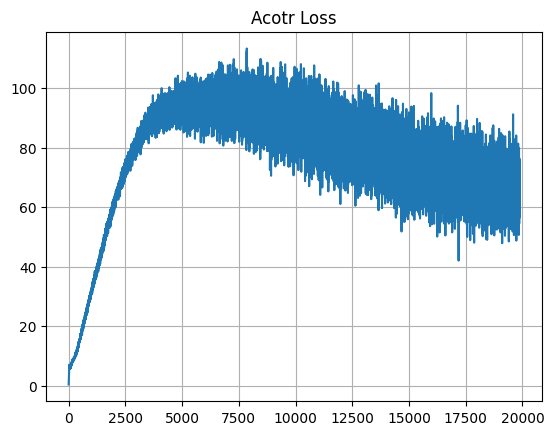

In [7]:
# Reward Plot
plt.figure()
plt.plot(episode_rewards)
plt.grid(True)
plt.title("Episode Rewards")
plt.savefig("plots/episode_rewards.png")

# Critics Plot
plt.figure()
plt.plot(critic1_losses, label="Critic 1 Loss")
plt.plot(critic2_losses, label="Critic 2 Loss")
plt.legend()
plt.grid(True)
plt.title("Critic Losses")
plt.savefig("plots/critic_losses.png")

# Actor Plot
plt.figure()
plt.plot(actor_losses)
plt.grid(True)
plt.title("Acotr Loss")
plt.savefig("plots/actor_losses.png")


In [8]:
# Save Video
frames = []
observation, _ = eval_env.reset()

for _ in range(500):
    frame = eval_env.render()
    frames.append(frame)
    action = agent.choose_action(observation)
    observation, _, done, truncated, _ = eval_env.step(action)
    if done or truncated:
        observation, _ = eval_env.reset()

imageio.mimsave("videos/td3_pendulum.mp4", frames, fps=30)

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (500, 500) to (512, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


: 